In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import *
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn

In [2]:
path = Path('/DATA/WAMRI/salk/uri/Image_restoration_data/')
train_lr = path/'train_LR'
train_hr = path/'train_HR'
test_lr = path/'test_LR'
test_hr = path/'test_HR'

In [3]:
def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

def match_hr_fn(x):
    return hr_names_by_id[pull_id(x.name)]

lr_names_full = list(train_lr.glob('*.tif'))
lr_names_full.sort()
hr_names_by_id = {pull_id(hrfn.name):hrfn for hrfn in train_hr.glob('*.tif')}
test_label = list(hr_names_by_id.values())[0]

In [4]:
src = (GrayImageItemList
       .from_folder(train_lr, '*.tif', label_class=GrayImageItemList)
       .split_by_valid_func(lambda x: x.stem[-3] == '0')
       .label_from_func(match_hr_fn))

In [5]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

def charbonnier_loss(inputs, targets):
    eps = 1e-6;
    d = inputs - targets
    e = torch.sqrt(d**2 + eps)
    return e.mean()

#base_loss = F.l1_loss
base_loss = charbonnier_loss
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.wgts = layer_wgts
        self.metric_names = (['pixel',] + 
                             [f'feat_{i}' for i in range(len(layer_ids))] +
                             [f'gram_{i}' for i in range(len(layer_ids))])

    def make_features(self, hooks, x, clone=False):
        self.m_feat(x.repeat([1,3,1,1]))
        return [(o.clone() if clone else o) for o in hooks.stored]
    
    def forward(self, input, target):
        hooks = hook_outputs(self.loss_features, detach=False)
        out_feat = self.make_features(hooks, target, clone=True)
        in_feat = self.make_features(hooks, input)
        hooks.remove()
        
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                              for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
#feat_loss = FeatureLoss(vgg_m, blocks[3:4], [5])

In [6]:
gc.collect()

117

In [8]:
scale=4
n_resblocks=250
n_feats=16
res_scale= 0.1
model = WDSR(scale, n_resblocks, n_feats, res_scale, n_colors_in=1)
model = nn.DataParallel(model) #.eval().cuda()

In [9]:
sz_lr = 72
scale,bs = 4,24
sz_hr = sz_lr*scale
#loss = combo_edge_mse
#loss=feat_proj_loss
#loss=combo2
#loss = feat_loss
loss = charbonnier_loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


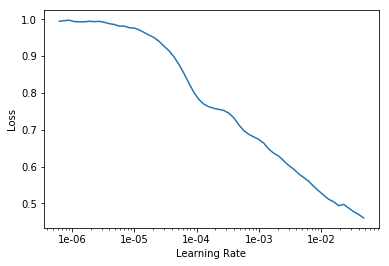

In [10]:
sz_lr = 256
scale,bs = 4,4
sz_hr = sz_lr*scale

learn = build_learner(model, bs, sz_lr, sz_hr, src, loss=loss) #, callback_fns=LossMetrics)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr
1,0.093112,0.162636,0.030062,0.135284,15.223323
2,0.058451,0.038924,0.008491,0.534200,20.719177
3,0.050939,0.038124,0.007369,0.219947,21.335976
4,0.043377,0.033232,0.007118,0.487272,21.483952
5,0.039074,0.030014,0.007095,0.743432,21.499601


save: wdsr_1.0


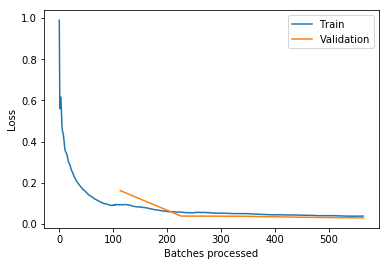

In [11]:
epochs, lr = 5, 1e-2
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, save='wdsr_1.0', loss=loss) #, callback_fns=[LossMetrics])

In [ ]:
torch.save(learn.model.module, "wdsr_model_1")

In [ ]:
sz_lr = 128
scale,bs = 4,8
sz_hr = sz_lr*scale
epochs, lr = 5, 1e-4
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, load='wdsr_1.0_best', save='wdsr_1.1', loss=loss) #, callback_fns=[LossMetrics])

In [ ]:
learn = learn.load('wdsr_1.1')
torch.save(learn.model.module,'wdsr_model_1.1')

In [ ]:
sz_lr = 200
scale,bs = 4,4
sz_hr = sz_lr*scale
epochs, lr = 5, 3e-5
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, load='wdsr_1.1_best', save='wdsr_1.2', loss=loss)

In [ ]:
learn = learn.load('wdsr_1.2')
torch.save(learn.model.module,'wdsr_model_1.2')

In [ ]:
sz_lr = 506
scale,bs = 4,1
sz_hr = sz_lr*scale
epochs, lr = 10, 1e-4
sz_lr = 506
scale,bs = 4,1
sz_hr = sz_lr*scale
data = get_data(src, bs, sz_lr, sz_hr)
learn = Learner(data, model, loss_func=loss).load('wdsr_1.2')
learn.fit_one_cycle(epochs, lr)

In [ ]:
learn = learn.load('wdsr_1.3')
torch.save(learn.model.module,'wdsr_model_1.3')

In [ ]:
learn = learn.load('wdsr_1.3_best')
torch.save(learn.model.module,'wdsr_model_1.3_best')

In [ ]:
sz_lr = 506
scale,bs = 4,1
sz_hr = sz_lr*scale
data = get_data(src, bs, sz_lr, sz_hr)
learn = Learner(data, model, loss_func=F.mse_loss).load('wdsr_1.0_best')
preds, ys = learn.get_preds(DatasetType.Valid)
preds = torch.clamp(preds, 0.,1.)

In [ ]:
idx = 9
ys[idx].std(), preds[idx].std()

In [ ]:
preds[idx].min(),preds[idx].max()

In [ ]:
hr = Image(ys[idx])
hr

In [ ]:
sr = Image(preds[idx])
sr

In [ ]:
lr = learn.data.valid_ds[idx][0]
data = lr.data.permute([1,2,0]).repeat([1,1,3]).detach().cpu().numpy()
img = PIL.Image.fromarray((data * 255).astype(np.uint8))
data = pil2tensor(img.resize((2024,2024), resample=PIL.Image.BICUBIC), dtype=np.float32)
lr = Image(data[0:1,:,:])
lr

In [ ]:
img1, img2 = sr.data[None],hr.data[None]
ssim.ssim(img1,img2), psnr(img1,img2), F.mse_loss(img1,img2)

In [ ]:
img1, img2 = lr.data[None],hr.data[None]
ssim.ssim(img1,img2), psnr(img1,img2), F.mse_loss(img1,img2)

In [ ]:
learn.save('wdsr')

In [ ]:
learn = learn.load('wdsr')

In [1]:
47*16

752